# 📦 EfficientNet-Based E-Waste Image Classification
This section covers the implementation, training, and evaluation of the EfficientNetV2B3 model for classifying e-waste images.

In [ ]:
!pip install tensorflow

### Importing Dependencies

In [ ]:
import tensorflow as tf  # Core TensorFlow library

from tensorflow.keras import layers, models, optimizers, callbacks  # Layers, model creation, optimizers, and training callbacks

from tensorflow.keras.models import Sequential, load_model  # For sequential model architecture and loading saved models

from tensorflow.keras.applications import EfficientNetV2B3  # Pretrained EfficientNetV2B0 model for transfer learning

from tensorflow.keras.applications.efficientnet import preprocess_input  # Preprocessing function specific to EfficientNet

import numpy as np  # Numerical operations and array handling

import matplotlib.pyplot as plt  # Plotting graphs and images

import seaborn as sns  # Plotting graphs and images

from sklearn.metrics import confusion_matrix, classification_report  # Evaluation metrics for classification models

import gradio as gr  # Web interface library to deploy and test ML models

from PIL import Image  # For image file loading and basic image operations


### Adding the Test, Train, Val dataset

In [ ]:
testpath= r'/content/drive/MyDrive/modified-dataset/test'
trainpath= r'/content/drive/MyDrive/modified-dataset/train'
validpath = r'/content/drive/MyDrive/modified-dataset/val'

### loading the Dataset to Keras of image size(300x300)

In [ ]:
datatrain = tf.keras.utils.image_dataset_from_directory(
    trainpath,
    shuffle=True,
    image_size=(300, 300),  # CHANGED
    batch_size=24,          # REDUCED
    validation_split=False
)

Found 2430 files belonging to 10 classes.


In [ ]:
datatest = tf.keras.utils.image_dataset_from_directory(
    testpath,
    shuffle=False,
    image_size=(300, 300),  # CHANGED
    batch_size=16,          # REDUCED
    validation_split=False
)

Found 300 files belonging to 10 classes.


In [ ]:
datavalid = tf.keras.utils.image_dataset_from_directory(
    validpath,
    shuffle=True,
    image_size=(300, 300),  # CHANGED
    batch_size=16,          # REDUCED
    validation_split=False
)

Found 300 files belonging to 10 classes.


In [ ]:
print(len(datatrain.class_names))
class_names = datatrain.class_names
print(class_names)

10
['Battery', 'Keyboard', 'Microwave', 'Mobile', 'Mouse', 'PCB', 'Player', 'Printer', 'Television', 'Washing Machine']


### Plotting the Images in the plots

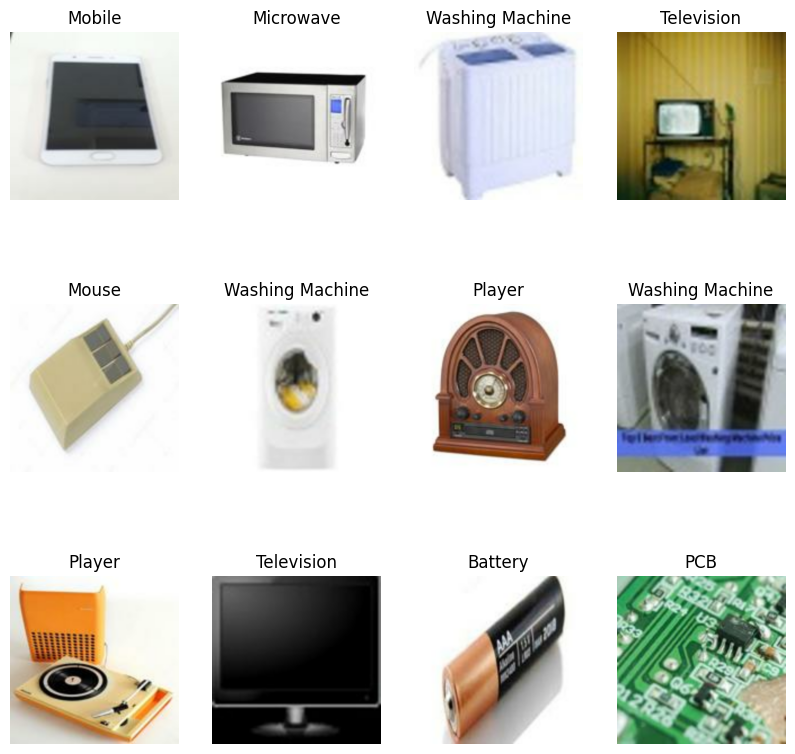

In [ ]:
# Set the size of the entire figure (width=10, height=10 inches)
plt.figure(figsize=(10, 10))

# Take one batch from the dataset and iterate over the images and labels
for images, labels in datatrain.take(1):
    # Display the first 12 images from the batch
    for i in range(12):
        # Create a 4x3 grid of subplots and select the (i+1)th position
        ax = plt.subplot(3, 4, i + 1)

        # Display the image; convert the tensor to a NumPy array and ensure correct type
        plt.imshow(images[i].numpy().astype("uint8"))

        # Set the title of the subplot to the class name of the image
        plt.title(class_names[labels[i]])

        # Remove axis ticks and labels for clarity
        plt.axis("off")

### Class Distribution of the Dataset

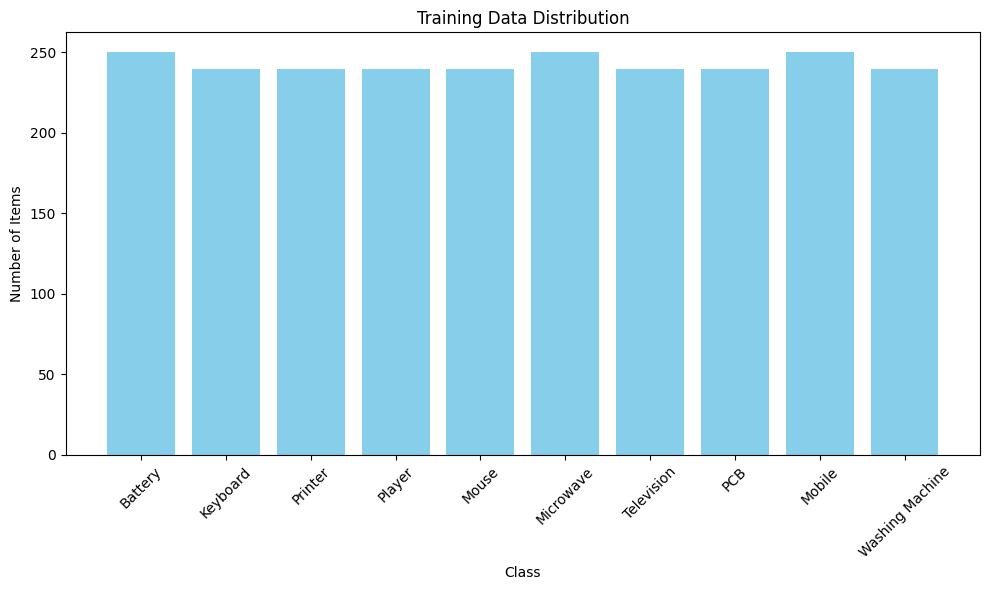

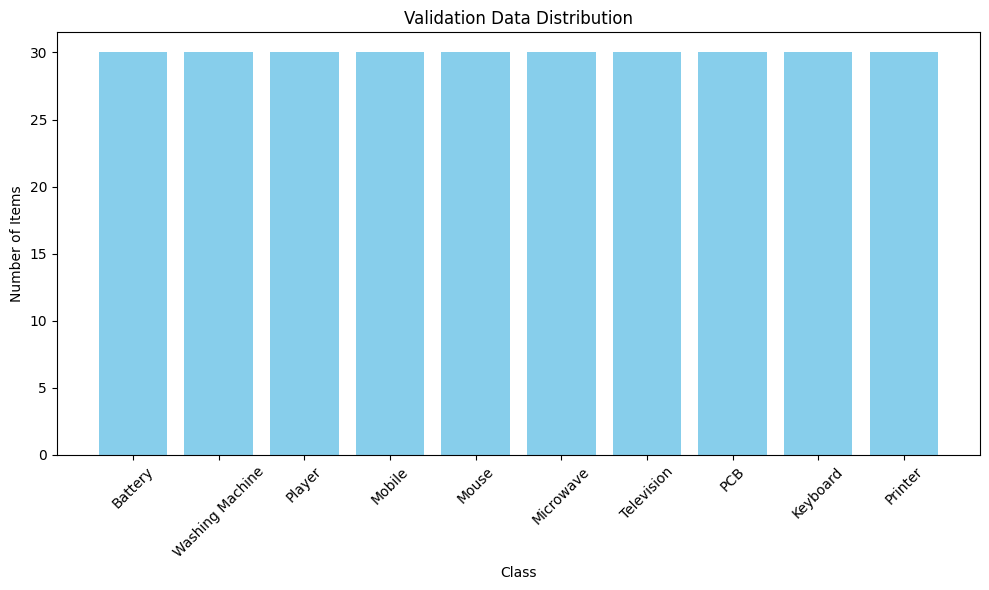

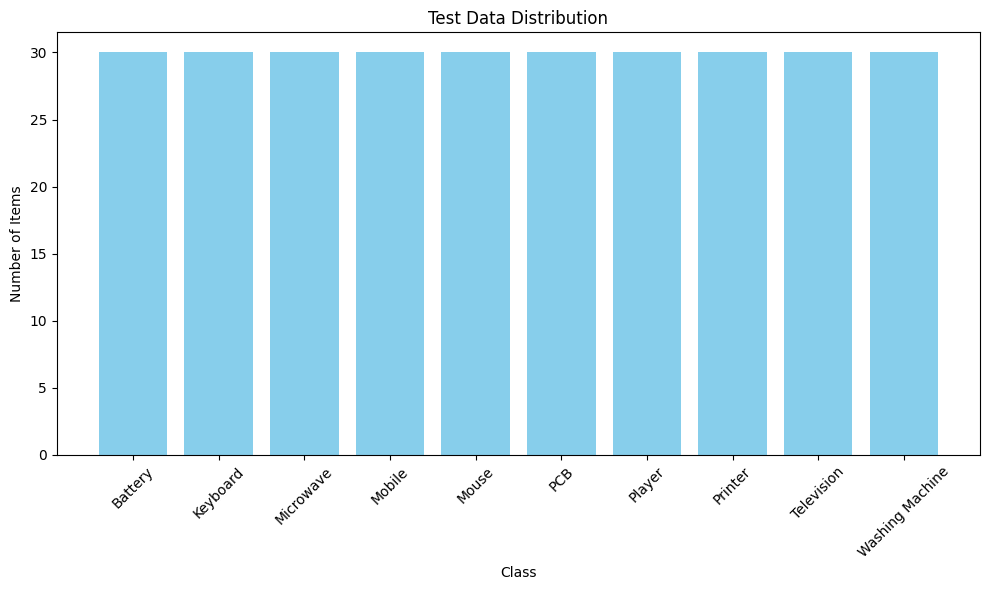

In [ ]:
def plot_class_distribution(dataset, title="Class Distribution"):
    """
    Plots the number of items per class in a given dataset.

    Args:
        dataset: A tf.data.Dataset object created using image_dataset_from_directory
        title: Title for the plot (e.g., 'Train Data Distribution')
    """

    class_counts = {}  # Dictionary to hold the count of each class

    # Iterate through the batches in the dataset
    for images, labels in dataset:
        # Convert labels tensor to numpy array and loop through each label
        for label in labels.numpy():
            class_name = dataset.class_names[label]  # Get class name using label index
            # Increment the count for this class
            class_counts[class_name] = class_counts.get(class_name, 0) + 1

    # Prepare data for plotting
    class_names = list(class_counts.keys())  # List of class names
    counts = list(class_counts.values())     # Corresponding counts for each class

    # Create the bar plot
    plt.figure(figsize=(10, 6))  # Set the figure size
    plt.bar(class_names, counts, color='skyblue')  # Draw bars with class counts
    plt.xlabel("Class")  # X-axis label
    plt.ylabel("Number of Items")  # Y-axis label
    plt.title(title)  # Plot title
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.tight_layout()  # Adjust layout to prevent clipping
    plt.show()  # Display the plot

plot_class_distribution(datatrain, "Training Data Distribution")
plot_class_distribution(datavalid, "Validation Data Distribution")
plot_class_distribution(datatest, "Test Data Distribution")

### Setting the Data Augmentation with application EfficientNetV2B3

In [ ]:

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])

In [ ]:
base_model = tf.keras.applications.EfficientNetV2B3(
    input_shape=(300, 300, 3),  # B3 optimal input size
    include_top=False,
    weights='imagenet'
)

52606240/52606240 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
base_model.trainable = True

# Smart freezing: Freeze 75% of layers for B3 stability
total_layers = len(base_model.layers)
freeze_until = int(total_layers * 0.75)

for i, layer in enumerate(base_model.layers):
    if i < freeze_until:
        layer.trainable = False
    # Keep BatchNormalization layers frozen for stability
    elif isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = False

print(f"Total layers in EfficientNetV2B3: {total_layers}")
print(f"Frozen layers: {freeze_until}")
print(f"Trainable layers: {sum(1 for layer in base_model.layers if layer.trainable)}")

Total layers in EfficientNetV2B3: 409
Frozen layers: 306
Trainable layers: 83


### Model Architecture

In [ ]:
# Model Architecture
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(300, 300, 3)),  # Updated input shape
    data_augmentation,
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.3),  # Increased dropout for larger model
    tf.keras.layers.Dense(10, activation='softmax')
])

In [ ]:
# Compilation with adjusted learning rate for B3
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00005),  # Lower LR for larger model
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']  # Changed from 'Accuracy' to 'accuracy'
)

In [ ]:
# Enhanced callbacks for B3
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,  # Increased patience for larger model
    restore_best_weights=True,
    verbose=1
)

In [ ]:
# Learning rate reduction callback
lr_reduction = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    patience=3,
    factor=0.5,
    min_lr=0.000001,
    verbose=1
)

In [ ]:
# Model checkpoint to save best model
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'best_efficientnetv2b3_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

### Running 20 Epochs of batch size 24

In [ ]:
# Training parameters
epochs = 20  # Increased epochs for B3
batch_size = 24  # Reduced batch size for memory efficiency

# Train the model
print("Starting training with EfficientNetV2B3...")
history = model.fit(
    datatrain,
    validation_data=datavalid,
    epochs=epochs,
    batch_size=batch_size,  # Smaller batch size for B3
    callbacks=[early_stopping, lr_reduction, checkpoint],  # Enhanced callbacks
    verbose=1
)

Starting training with EfficientNetV2B3...
Epoch 1/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.4486 - loss: 1.7698
Epoch 1: val_accuracy improved from -inf to 0.95667, saving model to best_efficientnetv2b3_model.h5



102/102 ━━━━━━━━━━━━━━━━━━━━ 803s 8s/step - accuracy: 0.4507 - loss: 1.7646 - val_accuracy: 0.9567 - val_loss: 0.1757 - learning_rate: 5.0000e-05
Epoch 2/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.8853 - loss: 0.4028
Epoch 2: val_accuracy improved from 0.95667 to 0.97000, saving model to best_efficientnetv2b3_model.h5



102/102 ━━━━━━━━━━━━━━━━━━━━ 734s 7s/step - accuracy: 0.8855 - loss: 0.4022 - val_accuracy: 0.9700 - val_loss: 0.0819 - learning_rate: 5.0000e-05
Epoch 3/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9313 - loss: 0.2256
Epoch 3: val_accuracy improved from 0.97000 to 0.98000, saving model to best_efficientnetv2b3_model.h5



102/102 ━━━━━━━━━━━━━━━━━━━━ 740s 7s/step - accuracy: 0.9314 - loss: 0.2255 - val_accuracy: 0.9800 - val_loss: 0.0560 - learning_rate: 5.0000e-05
Epoch 4/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9504 - loss: 0.1616
Epoch 4: val_accuracy did not improve from 0.98000
102/102 ━━━━━━━━━━━━━━━━━━━━ 744s 7s/step - accuracy: 0.9504 - loss: 0.1616 - val_accuracy: 0.9767 - val_loss: 0.0473 - learning_rate: 5.0000e-05
Epoch 5/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9645 - loss: 0.1381
Epoch 5: val_accuracy improved from 0.98000 to 0.98333, saving model to best_efficientnetv2b3_model.h5



102/102 ━━━━━━━━━━━━━━━━━━━━ 776s 8s/step - accuracy: 0.9644 - loss: 0.1381 - val_accuracy: 0.9833 - val_loss: 0.0419 - learning_rate: 5.0000e-05
Epoch 6/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9605 - loss: 0.1303
Epoch 6: val_accuracy improved from 0.98333 to 0.98667, saving model to best_efficientnetv2b3_model.h5



102/102 ━━━━━━━━━━━━━━━━━━━━ 790s 7s/step - accuracy: 0.9605 - loss: 0.1302 - val_accuracy: 0.9867 - val_loss: 0.0465 - learning_rate: 5.0000e-05
Epoch 7/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9707 - loss: 0.1028
Epoch 7: val_accuracy did not improve from 0.98667
102/102 ━━━━━━━━━━━━━━━━━━━━ 776s 7s/step - accuracy: 0.9707 - loss: 0.1027 - val_accuracy: 0.9833 - val_loss: 0.0450 - learning_rate: 5.0000e-05
Epoch 8/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9818 - loss: 0.0645
Epoch 8: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.

Epoch 8: val_accuracy did not improve from 0.98667
102/102 ━━━━━━━━━━━━━━━━━━━━ 743s 7s/step - accuracy: 0.9817 - loss: 0.0646 - val_accuracy: 0.9733 - val_loss: 0.0470 - learning_rate: 5.0000e-05
Epoch 9/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9795 - loss: 0.0652
Epoch 9: val_accuracy did not improve from 0.98667
102

In [ ]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 300, 300, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b3 (Functional)  │ (None, 10, 10, 1536)   │    12,930,622 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1536)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │        15,370 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,517,226 (93.53 MB)

 Trainable params: 5,785,616 (22.07 MB)

 Non-trainable params: 7,160,376 (27.31 MB)

 Optimizer params: 11,571,234 (44.14 MB)

In [ ]:
base_model.summary()

Model: "efficientnetv2-b3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 300, 300,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 300, 300,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 300, 300,  │          0 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 150, 150,  │      1,080 │ normalization[0]… │
│                     │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 150, 150,  │        160 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 150, 150,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 150, 150,  │      5,760 │ stem_activation[… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 150, 150,  │         64 │ block1a_project_… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_ac… │ (None, 150, 150,  │          0 │ block1a_project_… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_co… │ (None, 150, 150,  │      2,304 │ block1a_project_… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_bn  │ (None, 150, 150,  │         64 │ block1b_project_… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_ac… │ (None, 150, 150,  │          0 │ block1b_project_… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_drop        │ (None, 150, 150,  │          0 │ block1b_project_… │
│ (Dropout)           │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_add (Add)   │ (None, 150, 150,  │          0 │ block1b_drop[0][… │
│                     │ 16)               │            │ block1a_project_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_conv │ (None, 75, 75,    │      9,216 │ block1b_add[0][0] │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_bn   │ (None, 75, 75,    │        256 │ block2a_expand_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_act… │ (None, 75, 75,    │          0 │ block2a_expand_b

 Total params: 12,930,622 (49.33 MB)

 Trainable params: 5,770,246 (22.01 MB)

 Non-trainable params: 7,160,376 (27.31 MB)

### Plotting the Traing history graphs

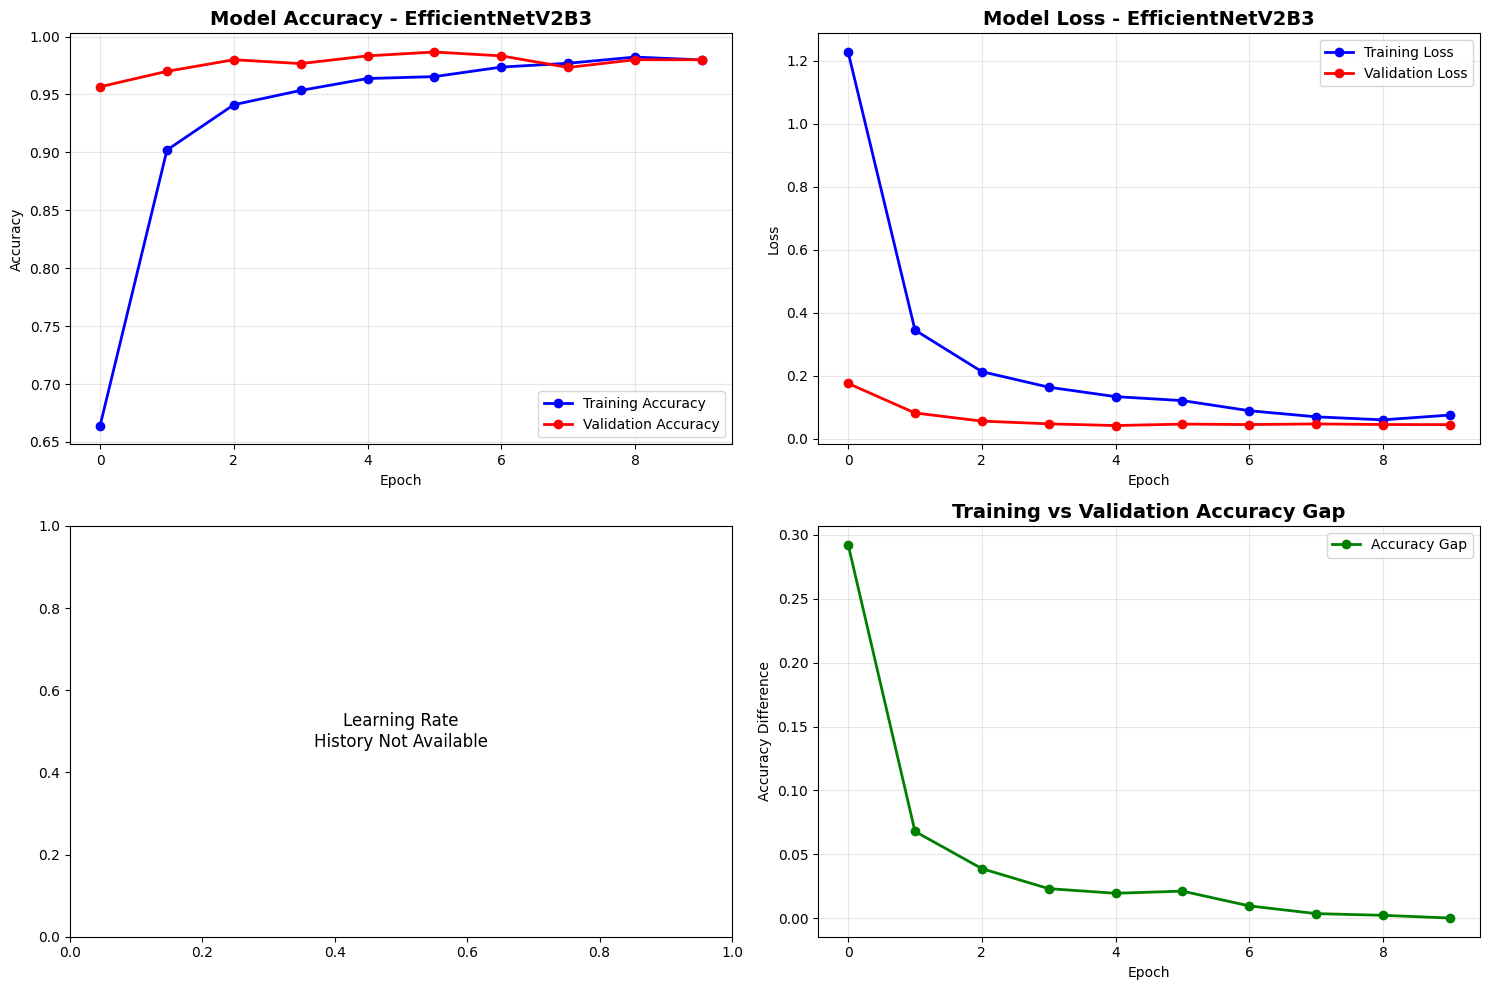

In [ ]:
def plot_training_history(history):
    """Enhanced training history visualization"""

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

    epochs_range = range(len(history.history['accuracy']))

    # Plot accuracy
    ax1.plot(epochs_range, history.history['accuracy'], 'bo-', label='Training Accuracy', linewidth=2)
    ax1.plot(epochs_range, history.history['val_accuracy'], 'ro-', label='Validation Accuracy', linewidth=2)
    ax1.set_title('Model Accuracy - EfficientNetV2B3', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Plot loss
    ax2.plot(epochs_range, history.history['loss'], 'bo-', label='Training Loss', linewidth=2)
    ax2.plot(epochs_range, history.history['val_loss'], 'ro-', label='Validation Loss', linewidth=2)
    ax2.set_title('Model Loss - EfficientNetV2B3', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # Plot learning rate (if available)
    if 'lr' in history.history:
        ax3.plot(epochs_range, history.history['lr'], 'go-', linewidth=2)
        ax3.set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
        ax3.set_xlabel('Epoch')
        ax3.set_ylabel('Learning Rate')
        ax3.set_yscale('log')
        ax3.grid(True, alpha=0.3)
    else:
        ax3.text(0.5, 0.5, 'Learning Rate\nHistory Not Available',
                ha='center', va='center', transform=ax3.transAxes, fontsize=12)
        ax3.set_xlim(0, 1)
        ax3.set_ylim(0, 1)

    # Plot accuracy difference
    acc_diff = [abs(train - val) for train, val in zip(history.history['accuracy'], history.history['val_accuracy'])]
    ax4.plot(epochs_range, acc_diff, 'go-', linewidth=2, label='Accuracy Gap')
    ax4.set_title('Training vs Validation Accuracy Gap', fontsize=14, fontweight='bold')
    ax4.set_xlabel('Epoch')
    ax4.set_ylabel('Accuracy Difference')
    ax4.legend()
    ax4.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Plot the training history
plot_training_history(history)


### Print final training results

In [ ]:
print("\n" + "="*60)
print("TRAINING COMPLETED - EWASTE CLASSIFICATION")
print("="*60)
print(f"Final Training Accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"Final Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")
print(f"Best Validation Accuracy: {max(history.history['val_accuracy']):.4f}")
print(f"Total Epochs Trained: {len(history.history['accuracy'])}")
print(f"Model saved as: best_efficientnetv2b3_ewaste_model.h5")


TRAINING COMPLETED - EWASTE CLASSIFICATION
Final Training Accuracy: 0.9798
Final Validation Accuracy: 0.9800
Best Validation Accuracy: 0.9867
Total Epochs Trained: 10
Model saved as: best_efficientnetv2b3_ewaste_model.h5


### Calculate overfitting metrics

In [ ]:
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]
overfitting_gap = final_train_acc - final_val_acc

print(f"\nModel Performance Analysis:")
print(f"Overfitting gap: {overfitting_gap:.4f}")
if overfitting_gap < 0.05:
    print("✅ Good generalization - Low overfitting")
elif overfitting_gap < 0.1:
    print("⚠️ Moderate overfitting")
else:
    print("❌ High overfitting - Consider regularization")

print("="*60)

# Memory optimization tips
print("\n" + "="*50)
print("MEMORY OPTIMIZATION TIPS FOR 300x300 IMAGES")
print("="*50)
print("If you encounter memory issues:")
print("1. Reduce batch_size further (try 12 or 8)")
print("2. Use mixed precision: tf.keras.mixed_precision.set_global_policy('mixed_float16')")
print("3. Clear GPU memory: tf.keras.backend.clear_session()")
print("4. Use gradient accumulation for effective larger batch sizes")
print("5. Consider using tf.data for more efficient data loading")
print("="*50)


Model Performance Analysis:
Overfitting gap: -0.0002
✅ Good generalization - Low overfitting

MEMORY OPTIMIZATION TIPS FOR 300x300 IMAGES
If you encounter memory issues:
1. Reduce batch_size further (try 12 or 8)
2. Use mixed precision: tf.keras.mixed_precision.set_global_policy('mixed_float16')
3. Clear GPU memory: tf.keras.backend.clear_session()
4. Use gradient accumulation for effective larger batch sizes
5. Consider using tf.data for more efficient data loading


### Confusion Matrix


Generating predictions for confusion matrix...
19/19 ━━━━━━━━━━━━━━━━━━━━ 71s 3s/step

Confusion Matrix:
[[28  0  0  0  0  0  0  1  0  1]
 [ 0 30  0  0  0  0  0  0  0  0]
 [ 0  0 30  0  0  0  0  0  0  0]
 [ 0  0  0 30  0  0  0  0  0  0]
 [ 0  0  0  0 30  0  0  0  0  0]
 [ 1  0  0  0  0 29  0  0  0  0]
 [ 0  0  0  0  0  0 30  0  0  0]
 [ 0  0  0  0  0  0  0 30  0  0]
 [ 0  0  1  0  1  0  0  0 28  0]
 [ 1  0  0  0  0  0  0  0  0 29]]

Classification Report:
                 precision    recall  f1-score   support

        Battery       0.93      0.93      0.93        30
       Keyboard       1.00      1.00      1.00        30
      Microwave       0.97      1.00      0.98        30
         Mobile       1.00      1.00      1.00        30
          Mouse       0.97      1.00      0.98        30
            PCB       1.00      0.97      0.98        30
         Player       1.00      1.00      1.00        30
        Printer       0.97      1.00      0.98        30
     Television       1.0

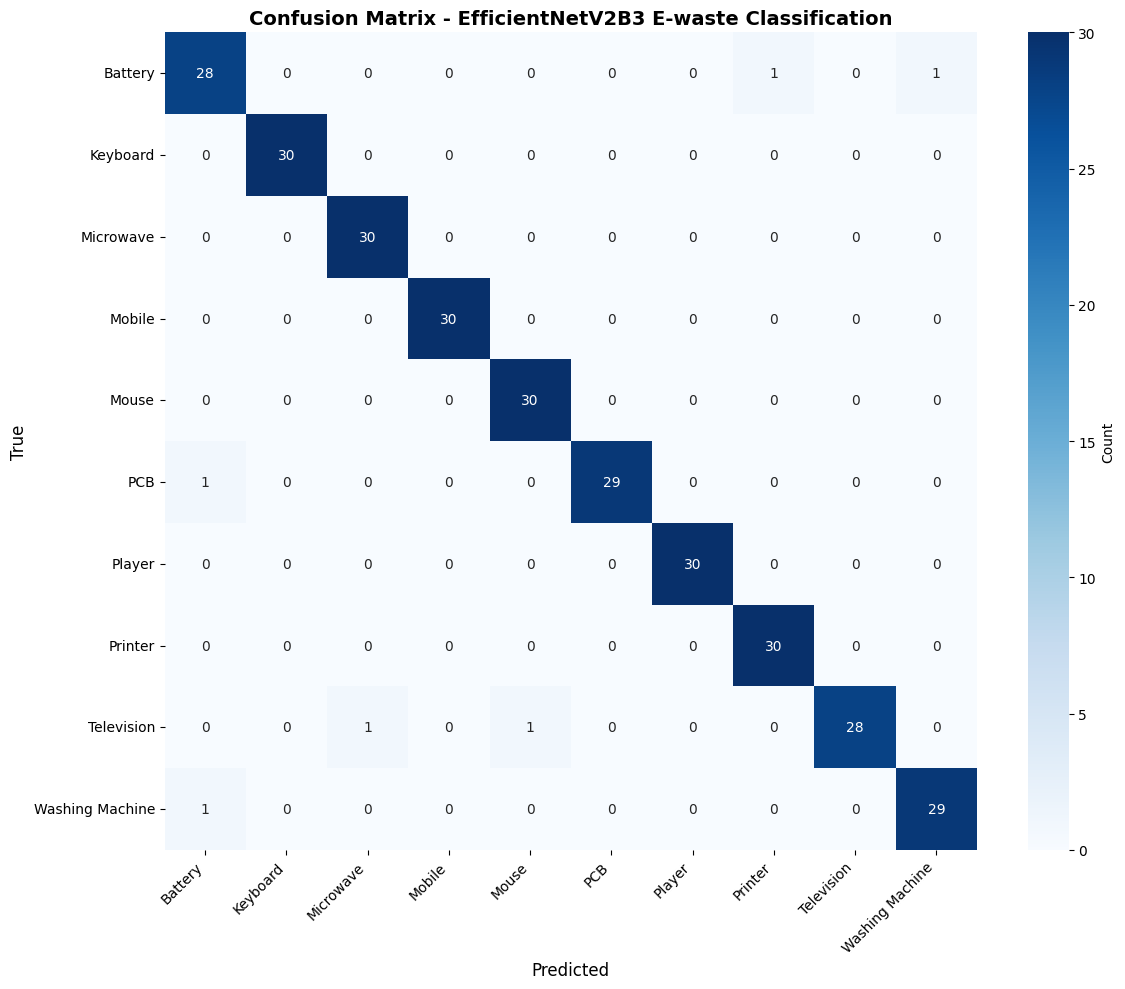

In [ ]:
print("\nGenerating predictions for confusion matrix...")
# Extract true labels from all batches
y_true = np.concatenate([y.numpy() for x, y in datatest], axis=0)  # Ground truth labels

# Get predictions as probabilities and then predicted classes
y_pred_probs = model.predict(datatest)

# Class with highest probability
y_pred = np.argmax(y_pred_probs, axis=1)

# Print confusion matrix and classification report
print("\nConfusion Matrix:")
print(confusion_matrix(y_true, y_pred))
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

### Plot Confusion Matrix as Heatmap for Better Visualization

cm = confusion_matrix(y_true, y_pred)                                     # Compute confusion matrix

plt.figure(figsize=(12, 10))                                               # Set figure size
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=class_names,
            yticklabels=class_names,
            cmap='Blues',
            cbar_kws={'label': 'Count'})                                               # Create heatmap with class labels

plt.xlabel('Predicted', fontsize=12)                                                   # Label for x-axis
plt.ylabel('True', fontsize=12)                                                        # Label for y-axis
plt.title('Confusion Matrix - EfficientNetV2B3 E-waste Classification', fontsize=14, fontweight='bold')                                             # Title for the plot
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

### Saving Model in Keras file format

In [ ]:
# Save model in Keras format with architecture, weights, and training configuration
model.save('Efficient_classify_v2b3.keras')
print("Model saved as: Efficient_classify_v2b3.keras")

Model saved as: Efficient_classify_v2b3.keras


# 📱 MobileNetV3-Based E-Waste Image Classification
This section demonstrates the MobileNetV3Large model applied to the same e-waste classification task, highlighting its lightweight architecture.


In [ ]:
!pip install tensorflow

### Importing Dependencies

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input as mobilenet_preprocess
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from PIL import Image
import json
import os

# Enable mixed precision for faster training
tf.keras.mixed_precision.set_global_policy('mixed_float16')

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU available: {tf.config.list_physical_devices('GPU')}")

TensorFlow version: 2.18.0
GPU available: []


### Loading the Datasets

In [ ]:
# Dataset paths
testpath = r'/content/drive/MyDrive/modified-dataset/test'
trainpath = r'/content/drive/MyDrive/modified-dataset/train'
validpath = r'/content/drive/MyDrive/modified-dataset/val'

### Using (128x128) size for the MobileNetV3Large model

In [ ]:
# Load datasets with (128,128) size - optimal for web deployment
datatrain = tf.keras.utils.image_dataset_from_directory(
    trainpath, shuffle=True, image_size=(128, 128), batch_size=32, validation_split=False
)
datatest = tf.keras.utils.image_dataset_from_directory(
    testpath, shuffle=False, image_size=(128, 128), batch_size=32, validation_split=False
)
datavalid = tf.keras.utils.image_dataset_from_directory(
    validpath, shuffle=True, image_size=(128, 128), batch_size=32, validation_split=False
)

print(f"Number of classes: {len(datatrain.class_names)}")
class_names = datatrain.class_names
print(f"Classes: {class_names}")

Found 2430 files belonging to 10 classes.
Found 300 files belonging to 10 classes.
Found 300 files belonging to 10 classes.
Number of classes: 10
Classes: ['Battery', 'Keyboard', 'Microwave', 'Mobile', 'Mouse', 'PCB', 'Player', 'Printer', 'Television', 'Washing Machine']


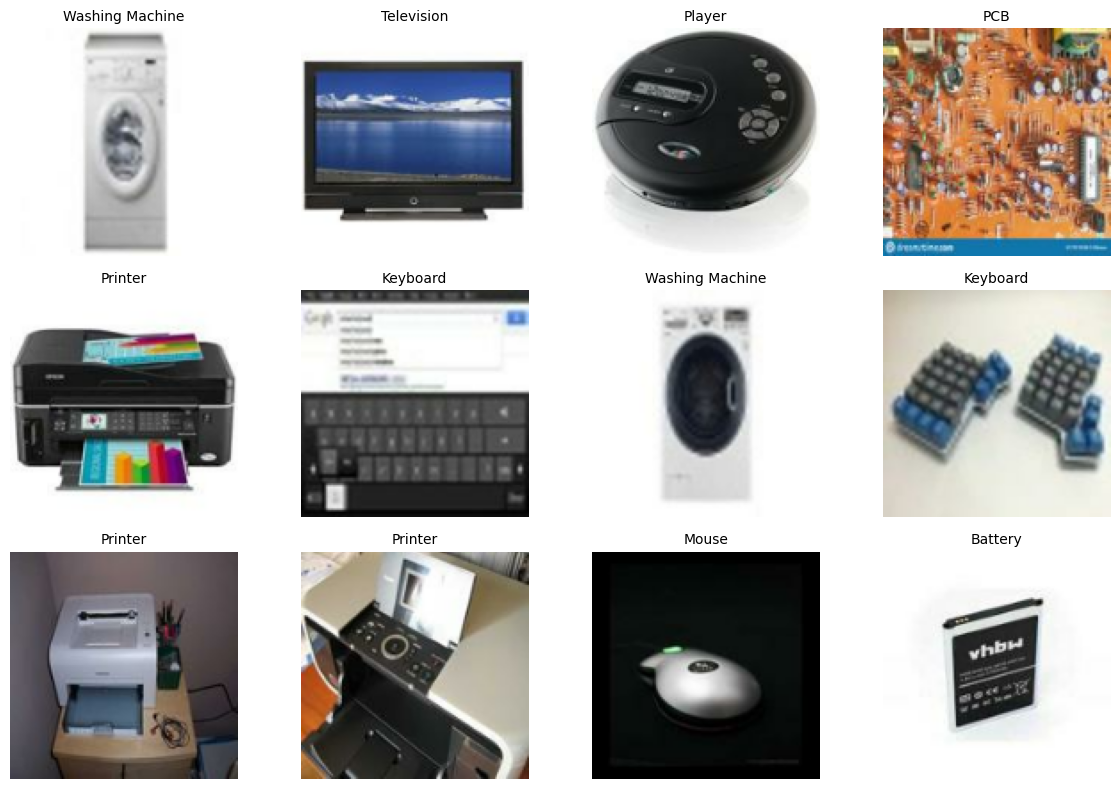

In [ ]:
plt.figure(figsize=(12, 8))
for images, labels in datatrain.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]], fontsize=10)
        plt.axis("off")
plt.tight_layout()
plt.show()

### Class Distribution Function

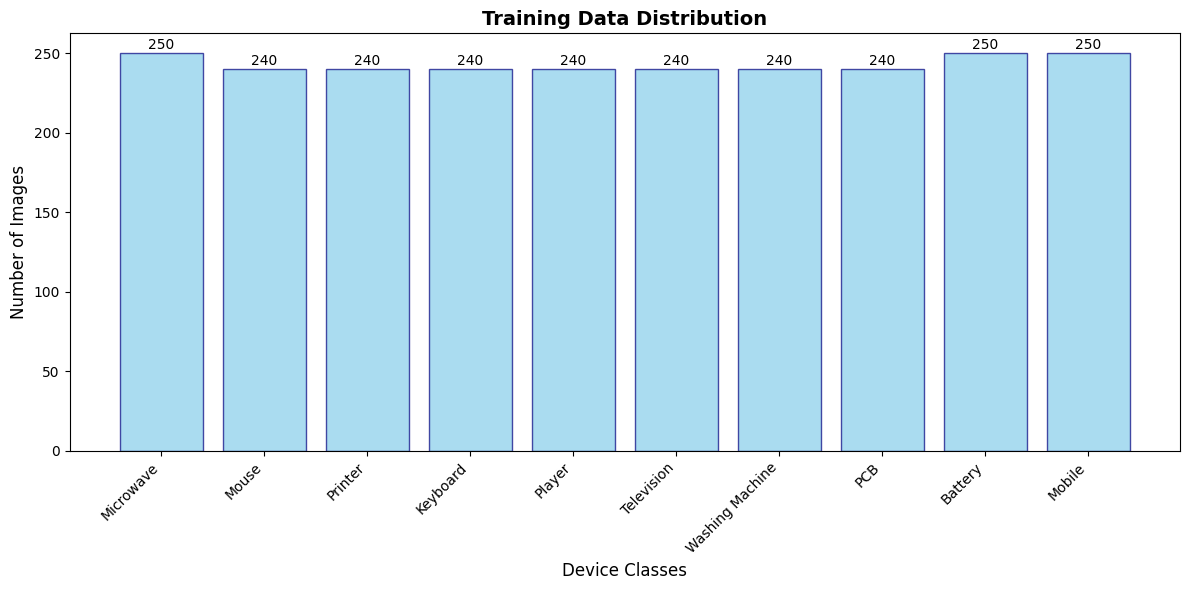

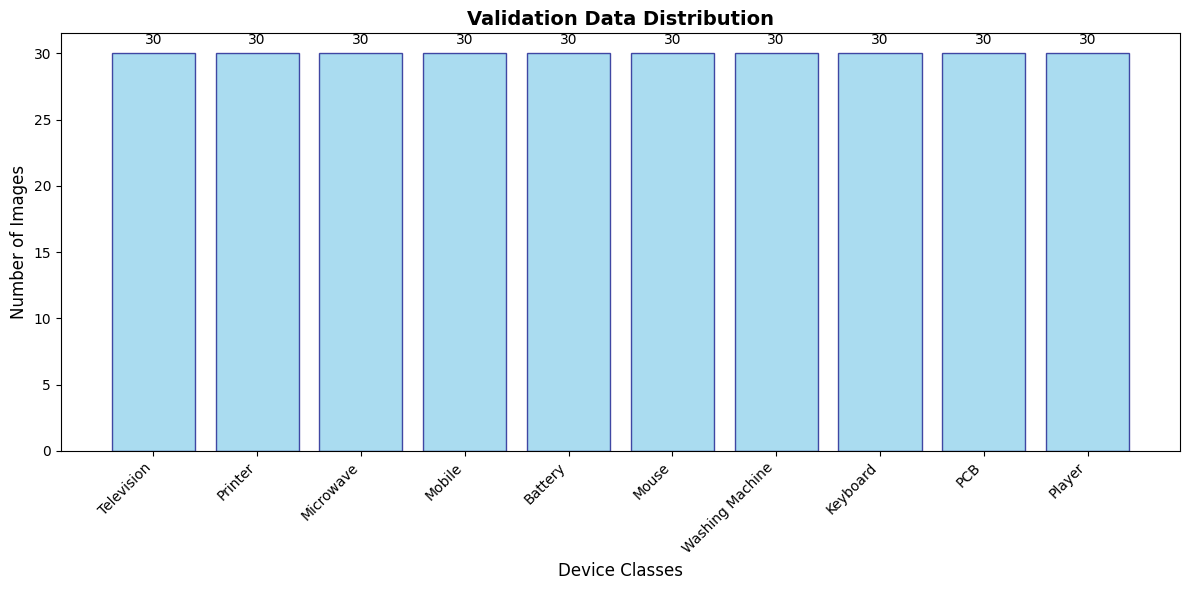

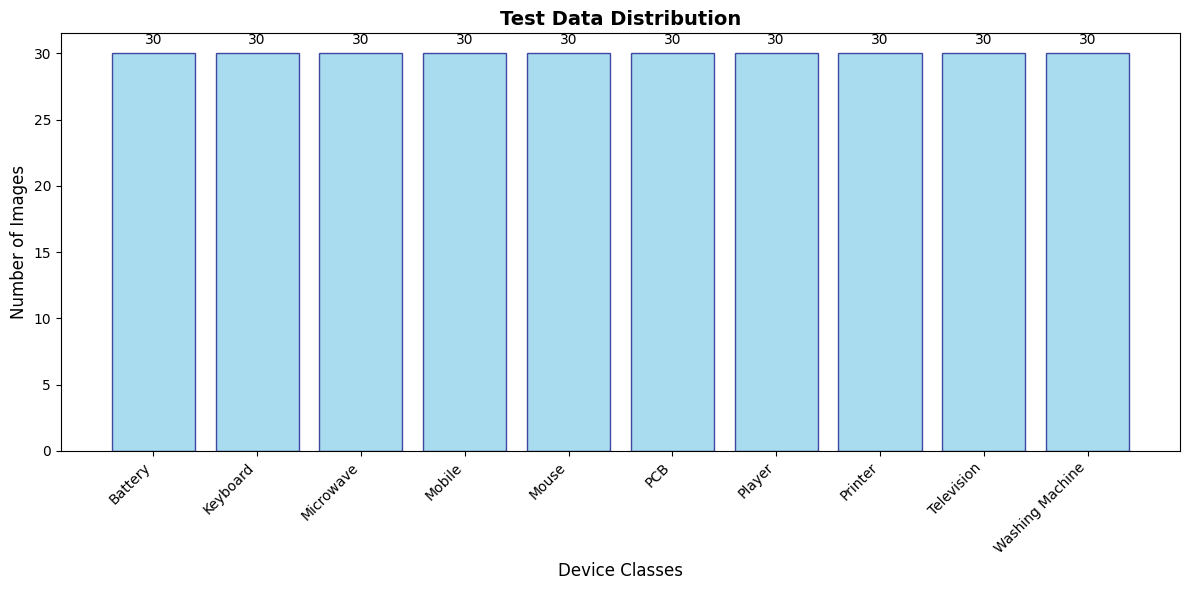

In [ ]:
def plot_class_distribution(dataset, title="Class Distribution"):
    """Plot class distribution for better understanding of data balance"""
    class_counts = {}
    for images, labels in dataset:
        for label in labels.numpy():
            class_name = class_names[label]  # Use global class_names
            class_counts[class_name] = class_counts.get(class_name, 0) + 1

    class_names_list = list(class_counts.keys())
    counts = list(class_counts.values())

    plt.figure(figsize=(12, 6))
    bars = plt.bar(class_names_list, counts, color='skyblue', edgecolor='navy', alpha=0.7)
    plt.xlabel("Device Classes", fontsize=12)
    plt.ylabel("Number of Images", fontsize=12)
    plt.title(title, fontsize=14, fontweight='bold')
    plt.xticks(rotation=45, ha='right')

    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{int(height)}', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

plot_class_distribution(datatrain, "Training Data Distribution")
plot_class_distribution(datavalid, "Validation Data Distribution")
plot_class_distribution(datatest, "Test Data Distribution")

### Data Augmentation

In [ ]:
# Web-optimized data augmentation (lighter for faster training)
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),      # Reduced for web stability
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomBrightness(0.1),
    tf.keras.layers.RandomContrast(0.1),
], name="data_augmentation")

# ===== MobileNetV3Large - OPTIMIZED FOR WEB DEPLOYMENT =====
print("=== Building MobileNetV3Large for Web Application ===")

=== Building MobileNetV3Large for Web Application ===


### Model Architecture

In [ ]:
# Load base model with optimal configuration for web deployment
base_model = MobileNetV3Large(
    input_shape=(128, 128, 3),
    include_top=False,
    weights='imagenet',
    alpha=1.0,                    # Full model for best accuracy
    minimalistic=False,           # Use full model features
    include_preprocessing=False   # We'll handle preprocessing separately
)

# Strategic fine-tuning for web deployment
base_model.trainable = True

# Fine-tune only the last layers for faster convergence and better web performance
total_layers = len(base_model.layers)
freeze_until = total_layers - 30  # Unfreeze last 30 layers

for i, layer in enumerate(base_model.layers):
    if i < freeze_until:
        layer.trainable = False
    # Keep BatchNormalization layers frozen for inference stability
    elif isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = False

print(f"Total layers: {total_layers}")
print(f"Trainable layers: {sum(1 for layer in base_model.layers if layer.trainable)}")
print(f"Frozen layers: {sum(1 for layer in base_model.layers if not layer.trainable)}")


Total layers: 186
Trainable layers: 24
Frozen layers: 162


In [ ]:
# Build model optimized for web deployment
model = Sequential([
    tf.keras.layers.Input(shape=(128, 128, 3), name="input_layer"),
    data_augmentation,

    # Preprocessing layer for consistent input handling
    tf.keras.layers.Rescaling(1./127.5, offset=-1, name="rescaling"),

    base_model,

    # Efficient head for web deployment
    tf.keras.layers.GlobalAveragePooling2D(name="global_avg_pool"),
    tf.keras.layers.Dropout(0.3, name="dropout_1"),

    # Additional dense layer for better feature learning
    tf.keras.layers.Dense(128, activation='relu', name="dense_128"),
    tf.keras.layers.Dropout(0.2, name="dropout_2"),

    # Output layer
    tf.keras.layers.Dense(10, activation='softmax', name="predictions")
], name="MobileNetV3Large_WebOptimized")

In [ ]:
# Check TensorFlow version and adjust optimizer accordingly
print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.18.0


### Using Adam Optimizer

In [ ]:
# Use Adam optimizer
optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    name="Adam"
)

In [ ]:
# Compile with mixed precision compatible configuration
model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Display model architecture
model.summary()

Model: "MobileNetV3Large_WebOptimized"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ data_augmentation (Sequential)  │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MobileNetV3Large (Functional)   │ (None, 4, 4, 960)      │     2,996,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_avg_pool                 │ (None, 960)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 960)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_128 (Dense)               │ (None, 128)            │       123,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,120,650 (11.90 MB)

 Trainable params: 1,710,698 (6.53 MB)

 Non-trainable params: 1,409,952 (5.38 MB)

In [ ]:
# Custom callback for training monitoring
class WebTrainingLogger(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if hasattr(self.model.optimizer, 'learning_rate'):
            if hasattr(self.model.optimizer.learning_rate, 'numpy'):
                lr = self.model.optimizer.learning_rate.numpy()
            else:
                lr = self.model.optimizer.learning_rate
        else:
            lr = 0.001  # fallback
        print(f"Epoch {epoch + 1}: LR = {lr:.6f}, "
              f"Accuracy = {logs['accuracy']:.4f}, "
              f"Val Accuracy = {logs['val_accuracy']:.4f}")

### Useful functions

In [ ]:
# Early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=8,
    restore_best_weights=True,
    verbose=1,
    mode='max',
    min_delta=0.001
)

# Learning rate reduction
lr_reduction = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    patience=4,
    factor=0.5,
    min_lr=1e-7,
    verbose=1,
    cooldown=1
)

# Model checkpoint - Fixed to save as .keras format
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'mobilenetv3_large_web_model.keras',  # Changed to .keras format
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=False,
    mode='max',
    verbose=1
)

### Running Epoch for 10 of batch size 32
##### Here the model has been trained but unfortunately the run time got disconnected but the model has saved the best model in the Keras format

In [ ]:
# Cell 11: Training Configuration
epochs = 20
batch_size = 32

print("Starting optimized training for web deployment...")
print(f"Model parameters: {model.count_params():,}")

# Cell 12: Training
# Training with callbacks
history = model.fit(
    datatrain,
    validation_data=datavalid,
    epochs=epochs,
    callbacks=[
        early_stopping,
        lr_reduction,
        checkpoint
    ],
    verbose=1
)

# The epoch got stoped because of the patience of 8 but i stopped it by 5 and the error it shows is just the same.
# This epoch has been trained in the google colab and suddenly the run time has timed out, But the best model has been saved in the keras file format.

Starting optimized training for web deployment...
Model parameters: 3,120,650
Epoch 1/20


KeyboardInterrupt: 

In [ ]:
model.summary()

Model: "MobileNetV3Large_WebOptimized"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ data_augmentation (Sequential)  │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MobileNetV3Large (Functional)   │ (None, 4, 4, 960)      │     2,996,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_avg_pool                 │ (None, 960)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 960)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_128 (Dense)               │ (None, 128)            │       123,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,542,052 (24.96 MB)

 Trainable params: 1,710,698 (6.53 MB)

 Non-trainable params: 1,409,952 (5.38 MB)

 Optimizer params: 3,421,402 (13.05 MB)

### Down below I have provided the difference between the models

In [ ]:
# Cell 13: Training History Visualization
def plot_training_history(history):
    """Training history plotting"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    # Accuracy plot
    ax1.plot(history.history['accuracy'], label='Training Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True)

    # Loss plot
    ax2.plot(history.history['loss'], label='Training Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

plot_training_history(history)

In [ ]:
# Cell 15: Model Evaluation
print("=== Web Model Evaluation ===")
test_results = model.evaluate(datatest, verbose=1)
print(f"Test Accuracy: {test_results[1]:.4f}")
print(f"Test Top-2 Accuracy: {test_results[2]:.4f}")
print(f"Test Top-3 Accuracy: {test_results[3]:.4f}")
print(f"Test Loss: {test_results[0]:.4f}")

In [ ]:
# Cell 16: Confusion Matrix and Classification Report
# Generate predictions for detailed analysis
y_true = np.concatenate([y.numpy() for x, y in datatest], axis=0)
y_pred_probs = model.predict(datatest, verbose=1)
y_pred = np.argmax(y_pred_probs, axis=1)

print("\n=== Detailed Performance Analysis ===")
print("Confusion Matrix:")
cm = confusion_matrix(y_true, y_pred)
print(cm)

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

In [ ]:
# Cell 17: Confusion Matrix Visualization
# Enhanced confusion matrix visualization
plt.figure(figsize=(12, 10))
sns.heatmap(cm,
            annot=True,
            fmt='d',
            xticklabels=class_names,
            yticklabels=class_names,
            cmap='Blues',
            cbar_kws={'label': 'Number of Predictions'})
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('Confusion Matrix - MobileNetV3Large Web Model', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# 🔍 Comparison Between EfficientNet and MobileNet Models
This section provides a detailed analysis and comparison of the performance, model size, and accuracy between EfficientNet and MobileNet.


### Load the trained model

In [ ]:
mobilenet_path = '/content/drive/MyDrive/mobilenetv3_large_web_model.keras'
efficientnet_path = '/content/drive/MyDrive/Efficient_classify_v2b3.keras'

In [ ]:
# Common parameters
testpath = '/content/drive/MyDrive/modified-dataset/test'
batch_size = 32  # Adjust based on what you used before

# For MobileNetV3Large (128x128)
datatest_mobile = tf.keras.utils.image_dataset_from_directory(
    testpath,
    shuffle=False,
    image_size=(128, 128),
    batch_size=batch_size
)

# For EfficientNetV2B3 (300x300)
datatest_efficient = tf.keras.utils.image_dataset_from_directory(
    testpath,
    shuffle=False,
    image_size=(300, 300),
    batch_size=batch_size
)

# Save class names
class_names = datatest_mobile.class_names

Found 300 files belonging to 10 classes.
Found 300 files belonging to 10 classes.


### Evalutation using the test dataset to show the difference in the accuracy

In [ ]:
# Load models
mobilenet_model = tf.keras.models.load_model(mobilenet_path)
efficientnet_model = tf.keras.models.load_model(efficientnet_path)

# Evaluate MobileNet
print("📊 MobileNetV3Large Evaluation:")
mobile_loss, mobile_acc = mobilenet_model.evaluate(datatest_mobile)
print(f"✅ Accuracy: {mobile_acc:.4f}")

# Evaluate EfficientNet
print("\n📊 EfficientNetV2B3 Evaluation:")
effnet_loss, effnet_acc = efficientnet_model.evaluate(datatest_efficient)
print(f"✅ Accuracy: {effnet_acc:.4f}")


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'Adam', because it has 38 variables whereas the saved optimizer has 42 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 52 variables whereas the saved optimizer has 102 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


📊 MobileNetV3Large Evaluation:
10/10 ━━━━━━━━━━━━━━━━━━━━ 51s 4s/step - accuracy: 0.9143 - loss: 0.2739
✅ Accuracy: 0.9167

📊 EfficientNetV2B3 Evaluation:
10/10 ━━━━━━━━━━━━━━━━━━━━ 74s 6s/step - accuracy: 0.9768 - loss: 0.1207
✅ Accuracy: 0.9800


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
def show_metrics(model, dataset, model_name="Model"):
    y_true = np.concatenate([y.numpy() for x, y in dataset], axis=0)
    y_pred = np.argmax(model.predict(dataset), axis=1)

    print(f"\n📄 Classification Report - {model_name}")
    print(classification_report(y_true, y_pred, target_names=class_names))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.title(f"{model_name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


### Metrics for MobileNetV3Large and the Confusion Matrix

10/10 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step

📄 Classification Report - MobileNetV3Large
                 precision    recall  f1-score   support

        Battery       0.96      0.83      0.89        30
       Keyboard       1.00      1.00      1.00        30
      Microwave       0.87      0.90      0.89        30
         Mobile       1.00      1.00      1.00        30
          Mouse       0.91      0.97      0.94        30
            PCB       0.97      0.97      0.97        30
         Player       0.91      0.70      0.79        30
        Printer       0.78      0.93      0.85        30
     Television       0.87      0.90      0.89        30
Washing Machine       0.94      0.97      0.95        30

       accuracy                           0.92       300
      macro avg       0.92      0.92      0.92       300
   weighted avg       0.92      0.92      0.92       300



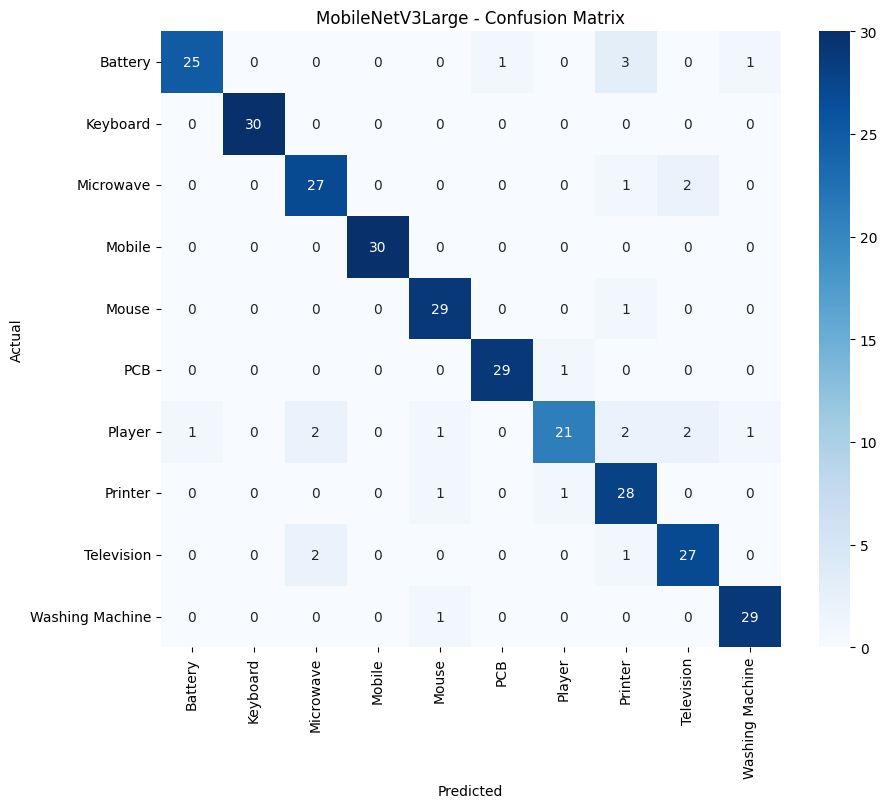

In [ ]:
show_metrics(mobilenet_model, datatest_mobile, "MobileNetV3Large") # Metrics for MobileNetV3Large

### Metrics for EfficientNetV2B3 and the Confusion Matrix

10/10 ━━━━━━━━━━━━━━━━━━━━ 71s 7s/step

📄 Classification Report - EfficientNetV2B3
                 precision    recall  f1-score   support

        Battery       0.93      0.93      0.93        30
       Keyboard       1.00      1.00      1.00        30
      Microwave       0.97      1.00      0.98        30
         Mobile       1.00      1.00      1.00        30
          Mouse       0.97      1.00      0.98        30
            PCB       1.00      0.97      0.98        30
         Player       1.00      1.00      1.00        30
        Printer       0.97      1.00      0.98        30
     Television       1.00      0.93      0.97        30
Washing Machine       0.97      0.97      0.97        30

       accuracy                           0.98       300
      macro avg       0.98      0.98      0.98       300
   weighted avg       0.98      0.98      0.98       300



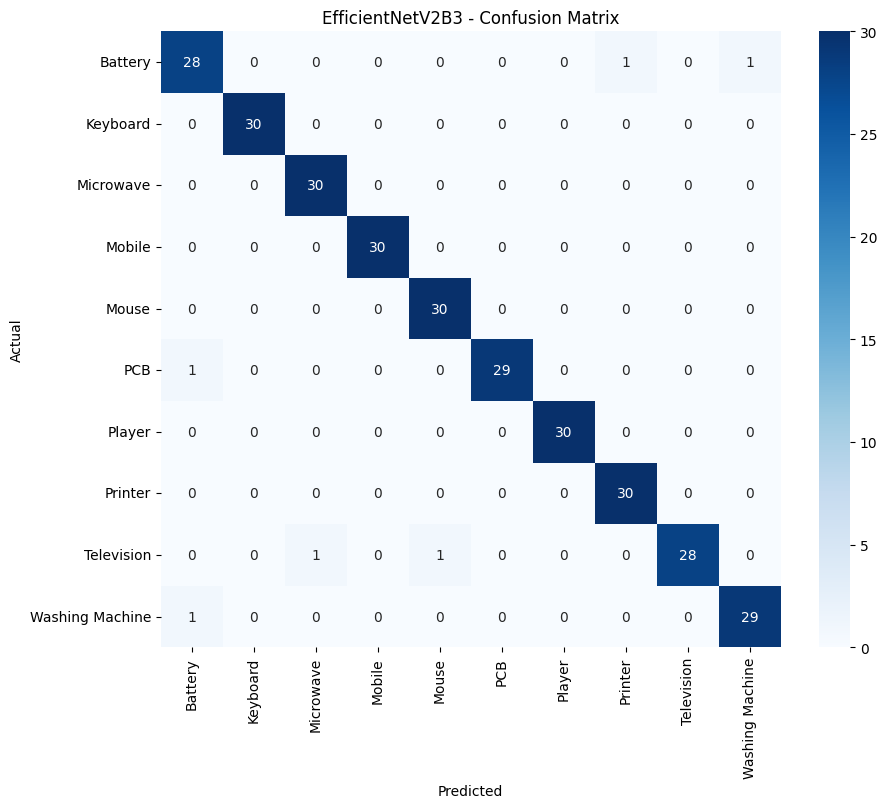

In [ ]:
show_metrics(efficientnet_model, datatest_efficient, "EfficientNetV2B3") # Metrics for EfficientNetV2B3